In [70]:
from typing import List, Tuple
import argparse
import json
from math import sqrt, ceil
import numpy as np
import matplotlib.pyplot as plt
import cirq
import openfermion as of
import qiskit
from qiskit.circuit.library import PauliEvolutionGate, phase_estimation
from qiskit.synthesis import LieTrotter
from qiskit import transpile
import quimb.tensor as qtn
from quimb.tensor.tensor_1d import MatrixProductState
from tensor_network_common import pauli_sum_to_mpo, pauli_string_to_mpo
from convert import cirq_pauli_sum_to_qiskit_pauli_op
from kcommute import commutes
from qpe_trotter import (
    group_single_strings,
    trotter_perturbation,
    bits_for_epsilon,
    get_gate_counts
)


In [71]:
l = 3
t = 1.0
u = 4.0
max_mpo_bond = 100
max_mps_bond = 15
evol_time = 0.1
energy_error = 1e-3

ham = of.fermi_hubbard(l, l, t, u, spinless=True)
ham_jw = of.transforms.jordan_wigner(ham)
nterms = len(ham_jw.terms)
print(f"Hamiltonian has {nterms} terms.")
ham_cirq = of.transforms.qubit_operator_to_pauli_sum(ham_jw)
qs = ham_cirq.qubits
blocks = [qs]
nq = len(qs)
print(f"Hamiltonian has {nq} qubits.")
ham_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(ham_cirq)
ham_mpo = pauli_sum_to_mpo(ham_cirq, qs, max_mpo_bond)

Hamiltonian has 64 terms.
Hamiltonian has 9 qubits.


## Calculate $\epsilon_2$ exactly.

In [72]:
# Get an approximate ground state using DMRG.
dmrg = qtn.tensor_dmrg.DMRG(ham_mpo, max_mps_bond)
converged = dmrg.solve()
if not converged:
    print("DMRG did not converge!")
ground_state = dmrg.state
ground_energy = dmrg.energy.real
print(f"Final DMRG energy: {ground_energy:4.5e}")

Final DMRG energy: -4.12311e+00


In [73]:
# Use the exact method.
groups = group_single_strings(ham_cirq)
v2 = trotter_perturbation(groups)
v2_mpo = pauli_sum_to_mpo(v2, qs, max_mpo_bond)
# Get energy from Mehendale Eqn. 8
eps2 = (ground_state.H @ v2_mpo.apply(ground_state)).real
print(f"eps2 = {eps2:4.5e}")
dt = sqrt(energy_error / eps2)
num_steps = ceil(evol_time / dt)
print(f"dt = {dt:4.5e}, n_steps = {num_steps}")


mu = 0
mu = 1
mu = 2
mu = 3
mu = 4
mu = 5
mu = 6
mu = 7
mu = 8
mu = 9
mu = 10
mu = 11
mu = 12
mu = 13
mu = 14
mu = 15
mu = 16
mu = 17
mu = 18
mu = 19
mu = 20
mu = 21
mu = 22
mu = 23
mu = 24
mu = 25
mu = 26
mu = 27
mu = 28
mu = 29
mu = 30
mu = 31
mu = 32
mu = 33
mu = 34
mu = 35
mu = 36
mu = 37
mu = 38
mu = 39
mu = 40
mu = 41
mu = 42
mu = 43
mu = 44
mu = 45
mu = 46
mu = 47
mu = 48
mu = 49
mu = 50
mu = 51
mu = 52
mu = 53
mu = 54
mu = 55
mu = 56
mu = 57
mu = 58
mu = 59
mu = 60
mu = 61
mu = 62
mu = 63
mu = 64
mu = 65
mu = 66
mu = 67
mu = 68
mu = 69
mu = 70
mu = 71
mu = 72
mu = 73
mu = 74
mu = 75
mu = 76
mu = 77
mu = 78
mu = 79
mu = 80
mu = 81
mu = 82
mu = 83
mu = 84
mu = 85
mu = 86
mu = 87
mu = 88
mu = 89
mu = 90
mu = 91
mu = 92
mu = 93
mu = 94
mu = 95
mu = 96
mu = 97
mu = 98
mu = 99
mu = 100
mu = 101
mu = 102
mu = 103
mu = 104
mu = 105
mu = 106
mu = 107
mu = 108
mu = 109
mu = 110
mu = 111
mu = 112
mu = 113
mu = 114
mu = 115
mu = 116
mu = 117
mu = 118
mu = 119
mu = 120
mu = 121
mu = 122
mu 

/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/autoray/autoray.py:81: RuntimeWarning: divide by zero encountered in matmul
  return func(*args, **kwargs)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/autoray/autoray.py:81: RuntimeWarning: overflow encountered in matmul
  return func(*args, **kwargs)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/autoray/autoray.py:81: RuntimeWarning: invalid value encountered in matmul
  return func(*args, **kwargs)


## Compute $\epsilon_2$ by uniform sampling of the terms.

In [74]:
def sample_eps2(
    hamiltonian: cirq.PauliSum, blocks: List[List[cirq.Qid]], ground_state: MatrixProductState,
    samples: int, interval: int=10
) -> Tuple[List[int], List[float], int]:
    """Estimate eps2 by sampling terms uniformly."""

    hamiltonian_terms = [ps for ps in hamiltonian]
    M = len(hamiltonian_terms)
    # To evaluate a sum by sampling, use the identity
    # sum_i f(x_i) = sum_i f(x_i) p(x_i) / p(x_i),
    # where p(x_i) is some probablitiy density function.
    # Then f(x_i) / p(x_i) is an estimator of the sum when we draw
    # x_i from p(x_i). For a uniform distribution, p(x_i) = N,
    # where N is the number of terms in the summations.
    num_summands = M ** 3 # TODO Fix me!
    sample_checkpoints = []
    sample_num_checkpoints = []
    num_zero = 0
    running_estimate = 0.
    for n in range(samples):
        mu = np.random.randint(0, 2 * M - 1)
        nu = np.random.randint(mu + 1, 2 * M)
        nu_prime = np.random.randint(nu, 2 * M)
        if mu >= M:
            i = mu - M
            h_mu = hamiltonian_terms[M - 1 - i]
        else:
            h_mu = hamiltonian_terms[mu]
        if nu >= M:
            i = nu - M
            h_nu = hamiltonian_terms[M - 1 - i]
        else:
            h_nu = hamiltonian_terms[nu]
        if nu_prime >= M:
            i = nu_prime - M
            h_nu_prime = hamiltonian_terms[M - 1 - i]
        else:
            h_nu_prime = hamiltonian_terms[nu_prime]
        if nu_prime == nu:
            delta = 1.
        else:
            delta = 0.
        if not commutes(h_nu, h_mu, blocks):
            comm_nu_mu = 2. * h_nu * h_mu # = [H_nu, H_mu] when they anti-commute.
            if not commutes(h_nu_prime, comm_nu_mu, blocks):
                # This term contributes.
                comm_three = 2. * h_nu_prime * comm_nu_mu
                comm_three_mpo = pauli_string_to_mpo(comm_three, qs)
                mat_elem = ground_state.H @ comm_three_mpo.apply(ground_state)
                running_estimate += (1 - delta / 2) * mat_elem.real * num_summands
            else:
                num_zero += 1
        if n % interval == 0 or n == samples:
            sample_checkpoints.append((-1 / 24.) * running_estimate / float(n + 1))
            sample_num_checkpoints.append(n+1)
    return sample_num_checkpoints, sample_checkpoints, num_zero

In [77]:
samples = 1_000_000
sample_nums, eps2_sampled, num_zero = sample_eps2(ham_cirq, blocks, ground_state, samples)
print(f"{num_zero} terms were zero.")

123597 terms were zero.


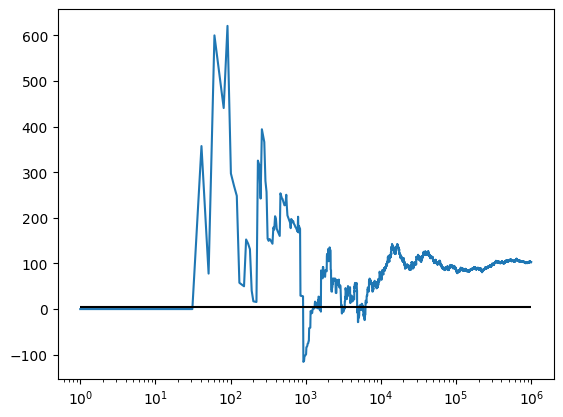

In [78]:
fig, ax = plt.subplots()
ax.plot(sample_nums, eps2_sampled)
ax.hlines(eps2, np.min(sample_nums), np.max(sample_nums), color="k")
ax.set_xscale("log")